#Фролов Владимир
**Stepik User ID: 541150734**

# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 11.4 MB/s eta 0:00:00


Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets
import os
import random

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [ ]:
seed = 42
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.empty_cache()
!nvidia-smi

cuda
Mon Jun  5 00:29:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [ ]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [ ]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = list(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.append(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [ ]:
train_dataset = WordDataset(dataset['train'])

seed_torch(seed)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [ ]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

In [ ]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type_base = {}
acc_type_base = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    seed_torch(seed)
    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_base[aggregation_type] = losses
    acc_type_base[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

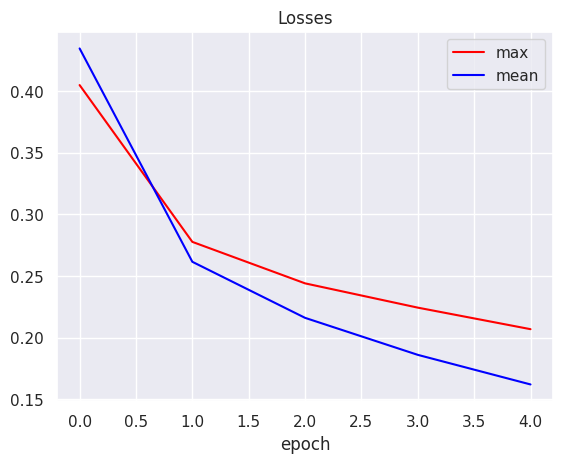

In [ ]:
for (name, values), color in zip(losses_type_base.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_base[name])), losses_type_base[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 90.84
Лучшая accuracy для подхода mean: 90.80


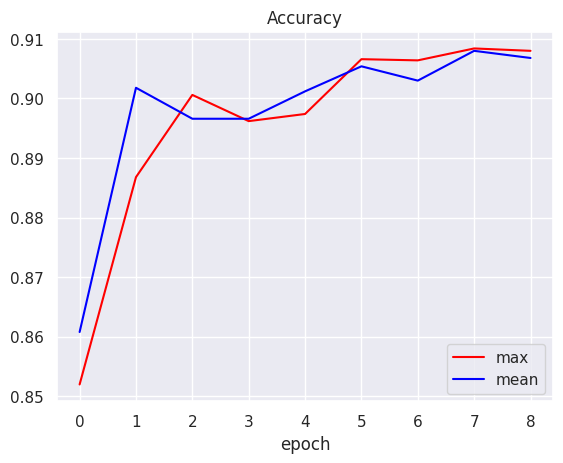

In [ ]:
for (name, values), color in zip(losses_type_base.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_base[name][1:])), acc_type_base[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_base[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

**Exp #1.** LSTM.

In [ ]:
class LSTMNet(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.lstm(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
losses_type_lstm = {}
acc_type_lstm = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    seed_torch(seed)
    model_lstm = LSTMNet(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_lstm.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_lstm.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_lstm(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_lstm.eval()
                acc.append(evaluate(model_lstm, eval_dataloader))
                model_lstm.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_lstm[aggregation_type] = losses
    acc_type_lstm[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

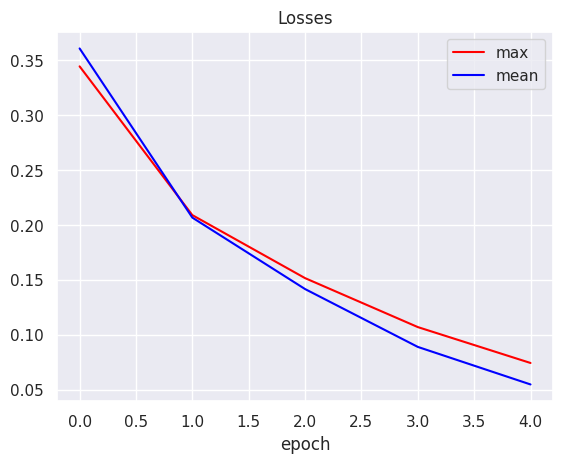

In [ ]:
for (name, values), color in zip(losses_type_lstm.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_lstm[name])), losses_type_lstm[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.24
Лучшая accuracy для подхода mean: 91.52


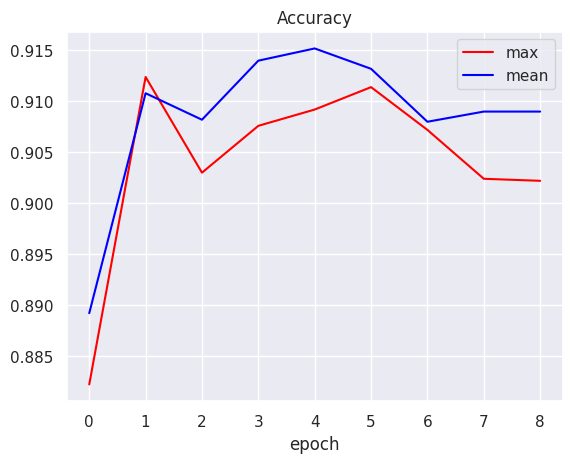

In [ ]:
for (name, values), color in zip(losses_type_lstm.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_lstm[name][1:])), acc_type_lstm[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_lstm[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

**Exp #2.** LSTM 2 layers.

In [ ]:
class LSTMNet2(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max', num_layers: int = 2
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.lstm(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
losses_type_lstm2 = {}
acc_type_lstm2 = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    seed_torch(seed)
    model_lstm2 = LSTMNet2(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_lstm2.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_lstm2.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_lstm2(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_lstm2.eval()
                acc.append(evaluate(model_lstm2, eval_dataloader))
                model_lstm2.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_lstm2[aggregation_type] = losses
    acc_type_lstm2[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

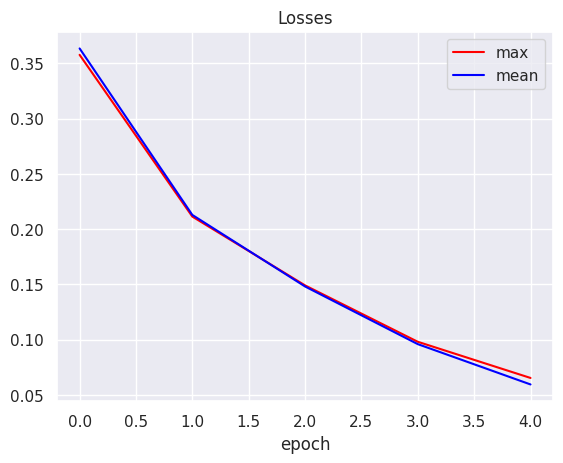

In [ ]:
for (name, values), color in zip(losses_type_lstm2.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_lstm2[name])), losses_type_lstm2[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.58
Лучшая accuracy для подхода mean: 91.58


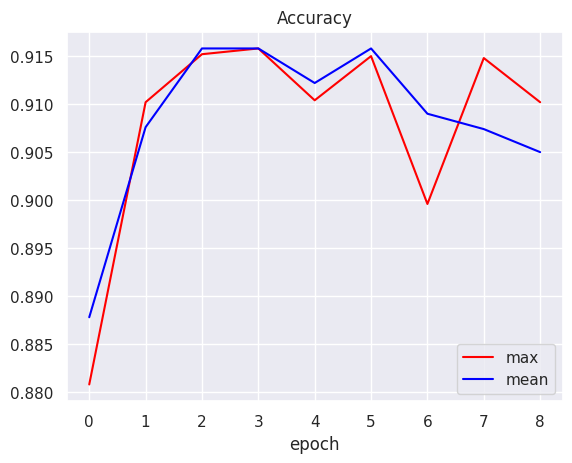

In [ ]:
for (name, values), color in zip(losses_type_lstm2.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_lstm2[name][1:])), acc_type_lstm2[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_lstm2[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

**Exp #3.** Dropout(p=0.25).

In [ ]:
class LSTMNet3(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max', num_layers: int = 2
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.25)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.lstm(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
losses_type_lstm3 = {}
acc_type_lstm3 = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    seed_torch(seed)
    model_lstm3 = LSTMNet3(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_lstm3.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_lstm3.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_lstm3(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_lstm3.eval()
                acc.append(evaluate(model_lstm3, eval_dataloader))
                model_lstm3.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_lstm3[aggregation_type] = losses
    acc_type_lstm3[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

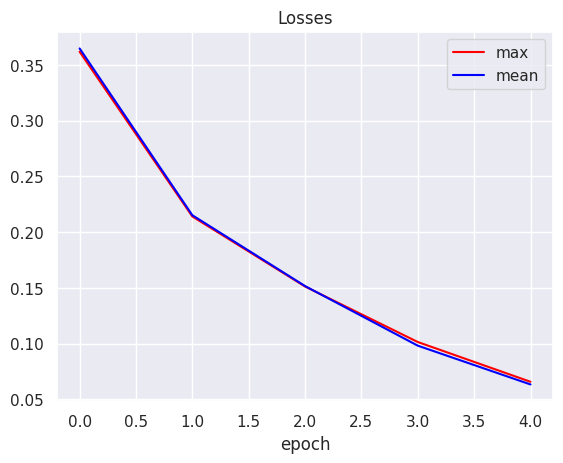

In [ ]:
for (name, values), color in zip(losses_type_lstm3.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_lstm3[name])), losses_type_lstm3[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.54
Лучшая accuracy для подхода mean: 91.50


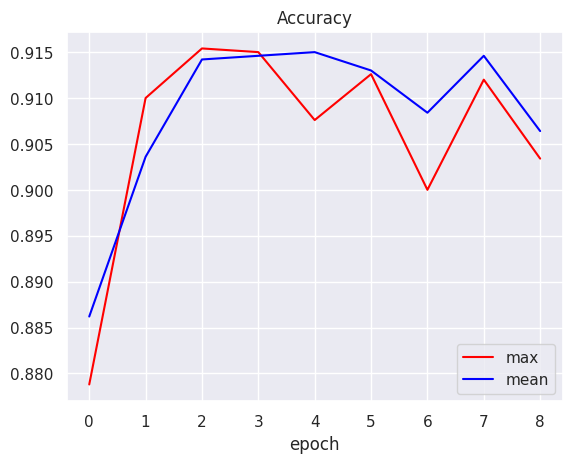

In [ ]:
for (name, values), color in zip(losses_type_lstm3.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_lstm3[name][1:])), acc_type_lstm3[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_lstm3[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

**Exp #4.** With dropout(p=0.25), hidden_dim=512, lr=3e-4, 10 epochs.

In [ ]:
num_epoch = 10

losses_type_lstm4 = {}
acc_type_lstm4 = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    seed_torch(seed)
    model_lstm4 = LSTMNet3(
        hidden_dim=512, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_lstm4.parameters(), lr=3e-4)

    for epoch in range(num_epoch):
        epoch_losses = []
        model_lstm4.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_lstm4(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_lstm4.eval()
                acc.append(evaluate(model_lstm4, eval_dataloader))
                model_lstm4.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_lstm4[aggregation_type] = losses
    acc_type_lstm4[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

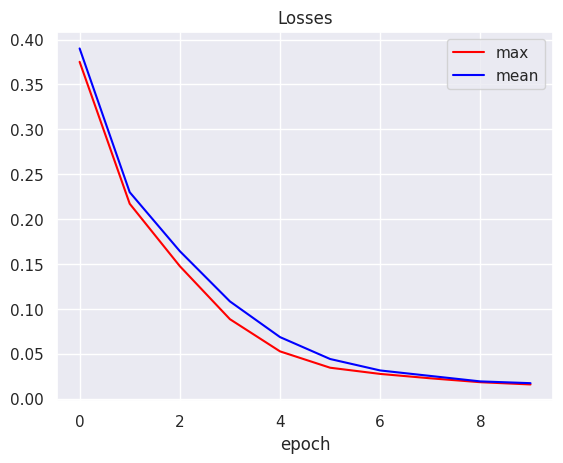

In [ ]:
for (name, values), color in zip(losses_type_lstm4.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_lstm4[name])), losses_type_lstm4[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.34
Лучшая accuracy для подхода mean: 91.32


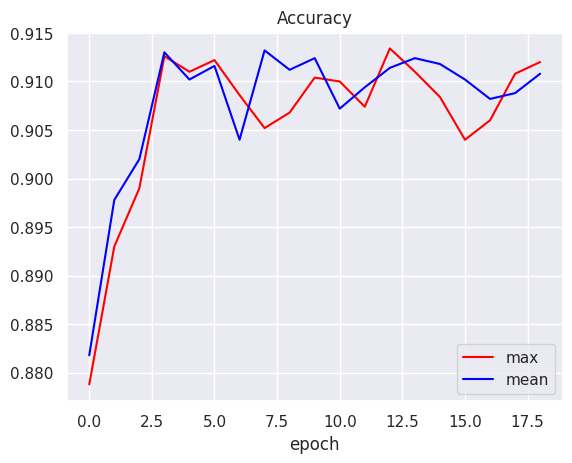

In [ ]:
for (name, values), color in zip(losses_type_lstm4.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_lstm4[name][1:])), acc_type_lstm4[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_lstm4[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

**Exp #5.** LSTM 3 layers + dropout(p=0.1) + hidden_dim=1024 + betas(0.5, 0.999) + scheduler + 10 epochs

In [ ]:
class LSTMNet4(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max', num_layers: int = 3
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.lstm(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
losses_type_lstm5 = {}
acc_type_lstm5 = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    seed_torch(seed)
    model_lstm5 = LSTMNet4(
        hidden_dim=1024, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_lstm5.parameters(), betas=(0.5, 0.999))
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

    for epoch in range(num_epoch):
        epoch_losses = []
        model_lstm5.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_lstm5(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_lstm5.eval()
                acc.append(evaluate(model_lstm5, eval_dataloader))
                model_lstm5.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))
        scheduler.step()

    losses_type_lstm5[aggregation_type] = losses
    acc_type_lstm5[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

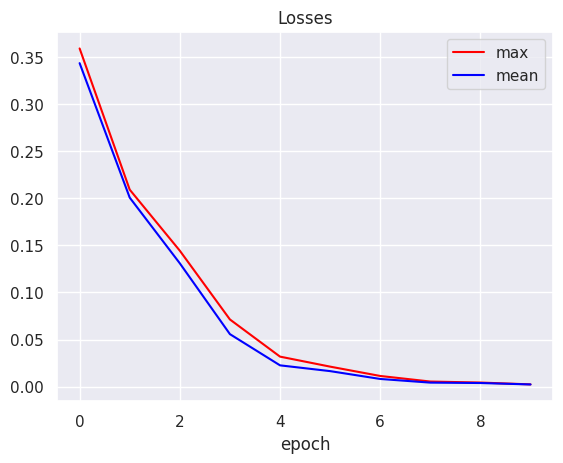

In [ ]:
for (name, values), color in zip(losses_type_lstm5.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_lstm5[name])), losses_type_lstm5[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 92.00
Лучшая accuracy для подхода mean: 92.02


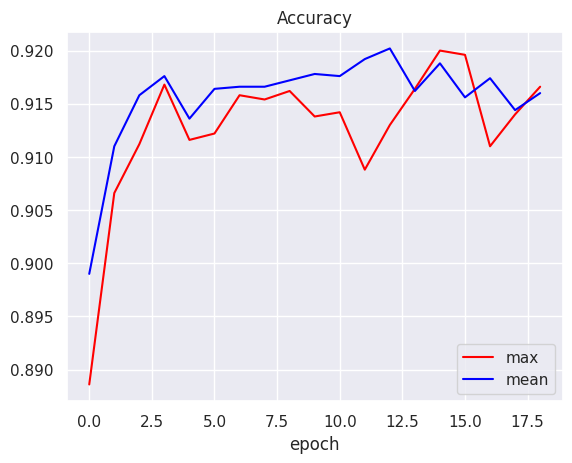

In [ ]:
for (name, values), color in zip(losses_type_lstm5.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_lstm5[name][1:])), acc_type_lstm5[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_lstm5[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

In [ ]:
import pandas as pd

data = np.array([max(acc_type_base['max']), max(acc_type_base['mean']), max(acc_type_lstm['max']),
                     max(acc_type_lstm['mean']), max(acc_type_lstm2['max']), max(acc_type_lstm2['mean']),
                     max(acc_type_lstm3['max']), max(acc_type_lstm3['mean']), max(acc_type_lstm4['max']),
                     max(acc_type_lstm4['mean']), max(acc_type_lstm5['max']), max(acc_type_lstm5['mean'])]).reshape(6, 2)
cols = ['accuracy for max', 'accuracy for mean']
rows = ['baseline', 'LSTM', 'LSTM 2 layers', 'LSTM 2 layers + dropout(p=0.25)',
        'LSTM 2 layers + dropout(p=0.25) + hidden_dim=512 + lr=3e-4 + 10 epochs',
        'LSTM 3 layers + dropout(p=0.1) + hidden_dim=1024 + betas(0.5, 0.999) + scheduler + 10 epochs']

df = pd.DataFrame(data=data, index=rows, columns=cols)
df

,accuracy for max,accuracy for mean
baseline,0.9084,0.9080
LSTM,0.9124,0.9152
LSTM 2 layers,0.9158,0.9158
LSTM 2 layers + dropout(p=0.25),0.9154,0.9150
LSTM 2 layers + dropout(p=0.25) + hidden_dim=512 + lr=3e-4 + 10 epochs,0.9134,0.9132
"LSTM 3 layers + dropout(p=0.1) + hidden_dim=1024 + betas(0.5, 0.999) + scheduler + 10 epochs",0.9200,0.9202


### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

###Отчёт.
Была обучена базовая модель с семинара и поставлено 5 экспериментов с LSTM:


*   Exp #1 - LSTM с параметрами базовой модели;
*   Exp #2 - LSTM c 2-мя слоями;
*   Exp #3 - LSTM с 2-мя слоями и увеличием дропаутов до 0.25
*   Exp #4 - LSTM c 2-мя слоями, а также с увеличением дропаутов до 0.25, скрытой размерности до 512, количества эпох обучения до 10 и изменением стандартного lr для Adam;
*   Exp #5 - LSTM c 3-мя слоями, а также с уменьшением дропаутов до исходного значения в 0.1, увеличением скрытой размерности до 1 024, количество эпох обучения оставили 10, вернули стандартный lr для Adam, однако изменили стандартные гиперпараметры betas и использовали lr scheduler;

Относительно безлайна улучшение принесли все осуществлённые эксперименты как для подхода "max", так и для подхода "mean". Лучший результат продемонстрировал последний эксперимент (Exp #5), однако с точки зрения времени обучения оно вряд ли того стоит (обучение длилось около 3-х часов, а улучшение относительно Exp #2 менее чем на 0.5%).

Анализируя графики сходимости можно отметить, что в целом сходимость была не слишком стабильная, однако колебания качества обученных моделей в большинстве своём незначительны (не более 1.5% по метрике - случайные выбросы). В этом смысле более стабильной сходимость была у базовой модели, у неё с уменьшением лосса стабильно повышалось качество. Очень печальным оказался тот факт, что увеличение скрытой размерности не дало сколь-либо значимого прироста качества, учитывая, что время обучения сильно возрастало. Увеличение количества эпох обучения в целом тоже не повлекло за собой сильного повышения качества и, судя по графикам лоссов, модель за 10 эпох выходит на плато, поэтому дальнейшее увеличение количества эпох скорее всего лишено смысла. Увеличение дропаутов способствовало ухудшению качества, однако показатели лосса для подходов с максимизацией и усреднением эмбеддингов оказались весьма и весьма близки. Добавление шедулера и изменение стандартного lr сильно не сказались на показателях метрики.

Наиболее оптимальной получилась модель LSTM с 2-мя слоями без каких-либо дополнений относительно бейзлайна (Exp #2). Она продемонстрировала одинаковое качество как для подхода "max", так и для подхода с усреднением эмбеддингов, по графикам метрики можно отметить единичный выброс случайного характера для "max". Что касается Exp #4 и #5, то увеличение скрытой размерности влечёт за собой сильное увеличение времени обучения, но не демонстрируют сильного увеличения качества модели. Поэтому увеличивать размерность скрытого пространства в данном случае не целесообразно. Время обучения остальных моделей такое же, как и у Exp #2, а базовая модель обучается даже немного быстрее, но и показатели метрики у неё ниже более чем на 0.5%.